# process spectra for AuxTel with new spectractor (version=2.3, December 2022, branch  auxtel_fit_PT) for particular config for Hologram

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : December 7th 2022
- update : 2022-12-07 (works with new kernel)

- version v3 : Work with exposure butlen gen3

This notebook is to help for finding the position of order 0

CCIN2P3:

- works with the new kernel **anaconda3_py39_auxtel** (with libradtran) 



# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.path)

['/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_12', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python39.zip', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/lib-dynload', '', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages', '__editable__.rubin_sim-0.13.1.finder.__path_hook__', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/libradtranpy-0.1.0-py3.9.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Django-4.1.3-py3.9.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/sqlparse-0.4.3-py3.9.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/

In [3]:
all_paths_to_remove = ['/opt/conda/lib/python3.8/site-packages','/pbs/home/d/dagoret/.local/lib/python3.8/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

In [4]:
sys.path

['/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_12',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python39.zip',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/lib-dynload',
 '',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages',
 '__editable__.rubin_sim-0.13.1.finder.__path_hook__',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/libradtranpy-0.1.0-py3.9.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Django-4.1.3-py3.9.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/sqlparse-0.4.3-py3.9.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/sit

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/bin/python
3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]


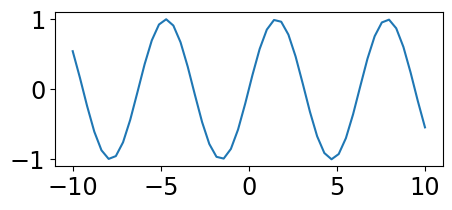

In [7]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               


In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.17.0'

In [10]:
import scipy
print(scipy.__version__)

1.9.1


In [11]:
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.images import *
from spectractor.config import load_config, set_logger
from scipy import ndimage, misc

In [12]:
import logging

In [13]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [14]:
from distutils.dir_util import copy_tree
import shutil

In [15]:
from astroquery.simbad import Simbad
import astroquery
astroquery.__version__
#result_table = Simbad.query_object("M1")

'0.4.6'

In [16]:
def find_target_name(tag):
    try:
        target_name=tag
        result_table = Simbad.query_object(target_name)
        return target_name
    except:
        target_name_stripped = ''.join(tag.split())
        result_table = Simbad.query_object(target_name_stripped)
        return target_name_stripped 
           

# Configuration

## Logger

In [17]:
my_logger = logging

## Config for the notebook

In [18]:
version="v5.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True
FLAG_RUNWITHEXCEPTIONS = False

## Configuration for Spectractor

In [19]:
print("List of configuration files available : ",os.listdir("config"))

List of configuration files available :  ['.ipynb_checkpoints', 'auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini']


In [20]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFMvNov2022.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DvNov2022.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini']

config_idx = len(list_of_spectractorconfigfiles)-1
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [21]:
configfilename

'./config/auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini'

In [22]:
configdir

'config_DECONVOLUTION_FFMvDec2022'

In [23]:
! pwd

/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_12


In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini


In [25]:
load_config(configfilename)

In [26]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg/spectractor/extractor/dispersers/
DISPLAY True
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_

# Exposure config

In [27]:
! ls logbooks

auxtellogbook_empty~holo4_003_20211103_v5.0.csv
auxtellogbook_empty~holo4_003_20211103_v5.0.xlsx
auxtellogbook_FELH0600~holo4_003_20211103_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211103_v5.0.xlsx


In [28]:
# path index for each month
DATE="20211103"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [29]:
disperser_label = filterdispersername.split("~")[-1]

## Paths

In [30]:
# select if we run at CC or not (locally) 
# /sps/lsst/groups/auxtel/data/2022/holo/20220317
HOSTCC=True
LAPTOP=False

In [31]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [32]:
path_images

'/sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20211103'

In [33]:
path_topoutput_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022'

In [34]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20211103'

# Utility Functions

In [35]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [36]:
!ls logbooks

auxtellogbook_empty~holo4_003_20211103_v5.0.csv
auxtellogbook_empty~holo4_003_20211103_v5.0.xlsx
auxtellogbook_FELH0600~holo4_003_20211103_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211103_v5.0.xlsx


In [37]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [38]:
filename_logbook

'logbooks/auxtellogbook_empty~holo4_003_20211103_v5.0.csv'

In [39]:
df=pd.read_csv(filename_logbook,index_col=0)

In [40]:
pd.set_option('display.max_rows', None)

In [41]:
# show the list of input files from the logbook to select the file index in the logbook
df

index                     date  \
0       0  2021-11-04T05:23:15.100   
1       1  2021-11-04T05:27:18.411   
2       2  2021-11-04T05:31:21.800   
3       3  2021-11-04T05:35:29.984   
4       4  2021-11-04T05:39:32.920   
5       5  2021-11-04T05:43:36.197   
6       6  2021-11-04T05:47:45.320   
7       7  2021-11-04T05:51:48.500   
8       8  2021-11-04T05:55:51.931   
9       9  2021-11-04T06:00:24.076   
10     10  2021-11-04T06:04:27.541   
11     11  2021-11-04T06:08:30.932   
12     12  2021-11-04T06:12:39.295   
13     13  2021-11-04T06:16:42.460   
14     14  2021-11-04T06:20:46.424   
15     15  2021-11-04T06:37:38.215   
16     16  2021-11-04T06:41:41.679   
17     17  2021-11-04T06:45:44.993   
18     18  2021-11-04T06:49:53.132   
19     19  2021-11-04T06:53:56.818   
20     20  2021-11-04T06:57:57.807   
21     21  2021-11-04T07:02:03.229   
22     22  2021-11-04T07:06:06.366   
23     23  2021-11-04T07:10:09.890   
24     24  2021-11-04T07:19:15.403   
25     25  2021-11-04T08:24:09.587   
26     26  2021-11-04T08:28:14.397   
27     27  2021-11-04T08:32:17.911   
28     28  2021-11-04T08:36:25.547   
29     29  2021-11-04T08:40:29.263   
30     30  2021-11-04T08:44:30.629   
31     31  2021-11-04T08:48:36.273   
32     32  2021-11-04T08:52:37.822   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
1   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
2   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
3   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
4   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
5   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
6   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
7   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
8   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
9   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
10  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
11  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
12  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
13  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
14  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
15  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
16  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
17  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
18  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
19  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
20  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
21  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
22  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
23  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
24  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
25  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
26  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
27  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
28  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
29  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
30  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
31  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
32  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   

                                      file  num    object   filter  disperser  \
0   exposure_2021110300459_postisrccd.fits  459  HD 38666  empty_1  holo4_003   
1   exposure_2021110300465_postisrccd.fits  465  HD 38666  empty_1  holo4_003   
2   exposure_2021110300471_postisrccd.fits  471  HD 38666  empty_1  holo4_003   
3   exposure_2021110300477_postisrccd.fits  477  HD 38666  empty_1  holo4_003   
4   exposure_2021110300483_postisrccd.fits  483  HD 38666  empty_1  holo4_003   
5   exposure_2021110300489_postisrccd.fits  489  HD 38666  empty_1  holo4_003   
6   exposure_2021110300495_postisrccd.fits  495  HD 38666  empty_1  holo4_003   
7   exposure_2021110300501_postisrccd.fits  501  HD 38666  empty_1  holo4_003   
8   exposure_2021110300507_postisrccd.fits 

# Selection of input file
- the input file is selected from the logbook list above

In [42]:
idx=7

In [43]:
print(df.iloc[idx]['file'])

exposure_2021110300501_postisrccd.fits


In [44]:
print(df.iloc[idx])

index                                                          7
date                                     2021-11-04T05:51:48.500
path           /sps/lsst/groups/auxtel/data/2022/empty~holo4_...
file                      exposure_2021110300501_postisrccd.fits
num                                                          501
object                                                  HD 38666
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.079841
exposure                                                    30.0
focus                                                   0.043359
seeing                                                  1.057946
pressure                                                   740.1
temperature                                                  7.5
humidity                                                    27.0
windspd                  

In [45]:
myhome=os.getenv("HOME")

In [46]:
dir_images=path_images

In [47]:
dir_images

'/sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20211103'

In [48]:
filename_image=df['file'][idx]
filename_image

'exposure_2021110300501_postisrccd.fits'

In [49]:
target = df['object'][idx]
target

'HD 38666'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [50]:
# ## If order 0 position exists in logbook it is selected, otherwise put it by hand

x0=300
y0=1700

if 'Obj-posXpix' in df.columns and 'Obj-posYpix' in df.columns:
    thex0 = df['Obj-posXpix'][idx]
    if not is_nan(thex0):
        x0=thex0
    they0 = df['Obj-posYpix'][idx]
    if not is_nan(they0):
        y0=they0
    
if not is_nan(x0) and not is_nan(y0):

    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

print(f"guess (x0,y0) = ({x0},{y0})")


Order 0 location from logbook : (300,1700)
guess (x0,y0) = (300,1700)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [51]:
rootfilename = filename_image.split(".")[0]
rootfilename_split =  rootfilename.split("_") 
filenumberdir = rootfilename_split[1] 

In [52]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20211103'

In [53]:
configdir

'config_DECONVOLUTION_FFMvDec2022'

In [54]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
#subdir=filename_image.split(".")[0]
subdir=filenumberdir

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)


# local directories to put spectra and plots
    
if configdir =="":
    output_directory="./outputs_process_" + DATE  + '_' + dispersername +'_nb_' + str(idx+1)
    output_figures="figures_process_" + DATE + '_' + dispersername + '_nb_' + str(idx+1)
else:
    output_directory = "./outputs_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    output_figures   = "./figures_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    
    

#guess = [300,1700]
guess = [350,1700]

# configuration

config=configfilename    
target=df.iloc[idx]["object"]

In [55]:
print(f"finalpath_output_spectractor = {finalpath_output_spectractor}")
print(f"output_directory = {output_directory}")
print(f"output_figures = {output_figures}")
print(f"config filename = {config}")

finalpath_output_spectractor = /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20211103/2021110300501
output_directory = ./outputs_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8
output_figures = ./figures_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8
config filename = ./config/auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini


In [56]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [57]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
    
# manage subdirs spectrum/ and plots/

if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)

# Configuration of the Spectractor running mode

In [58]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [59]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [60]:
target_name_sel0 = find_target_name(target)
print(f"target_name_sel0 = {target_name_sel0}")
#target_name_sel0 = ''.join(target.split())
#target_name_sel1 = target_name_sel0.encode(encoding='UTF-8',errors='strict')
#target_name_sel = target_name_sel0.encode()
target_name_sel = target_name_sel0.encode(encoding="ascii", errors="ignore")
print(f'target_name_sel = {target_name_sel}')
#target_name_sel=f"{target_name_sel}"

target_name_sel0 = HD 38666
target_name_sel = b'HD 38666'


## Load the image in the new image file with Spectractor

In [61]:
image=Image(file_name=filename, disperser_label=disperser_label,target_label=target_name_sel, config=config)

In [62]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [63]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [64]:
image.header["FILTER"]

'empty_1'

In [65]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-11-04T05:51:44.418'                                             
DATE-OBS= '2021-11-04T05:51:44.418'                                             
DATE-BEG= '2021-11-04T05:51:48.500'                                             
DATE-END= '2021-11-04T05:52:18.731'                                             
MJD     =     59522.2442641011                                                  
MJD-OBS =      59522.244311346                                                  
MJD-BEG =      59522.2443113

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

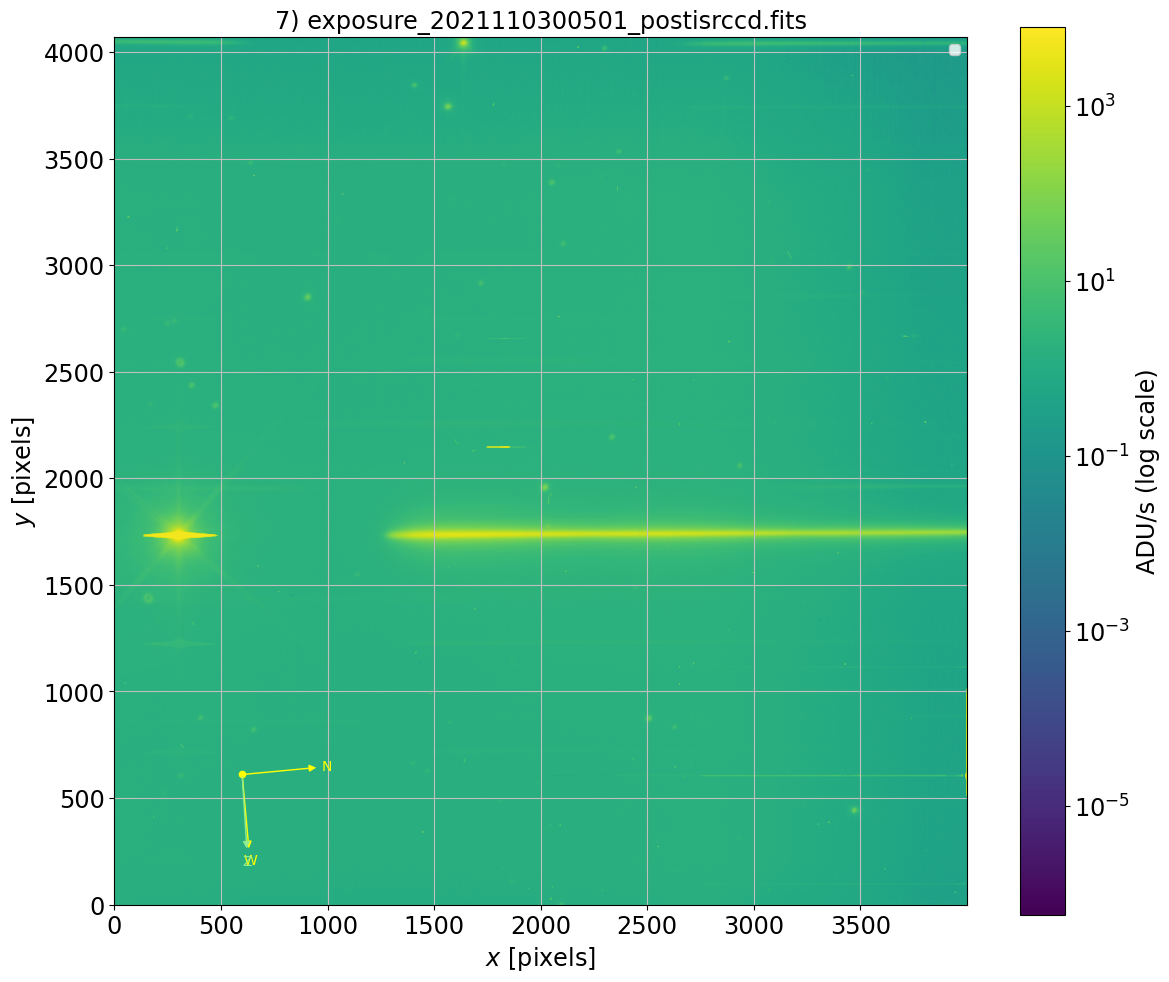

In [66]:
import matplotlib.pyplot as plt
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)
plt.show()

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [67]:
filename_image

'exposure_2021110300501_postisrccd.fits'

## Let Spectractor find the location of the 0th order

2022-12-07 14:22:00  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1       
    ------------------ -------------------- -------------------
    19.838626819112992 -0.08559897922217545 0.04380173282251023


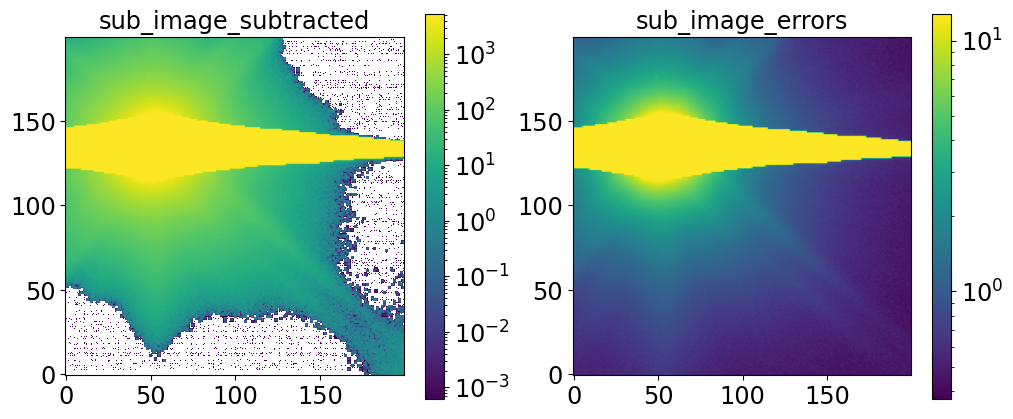

2022-12-07 14:22:09  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 18 iterations because the relative change of cost is below ftol=1.25e-05.


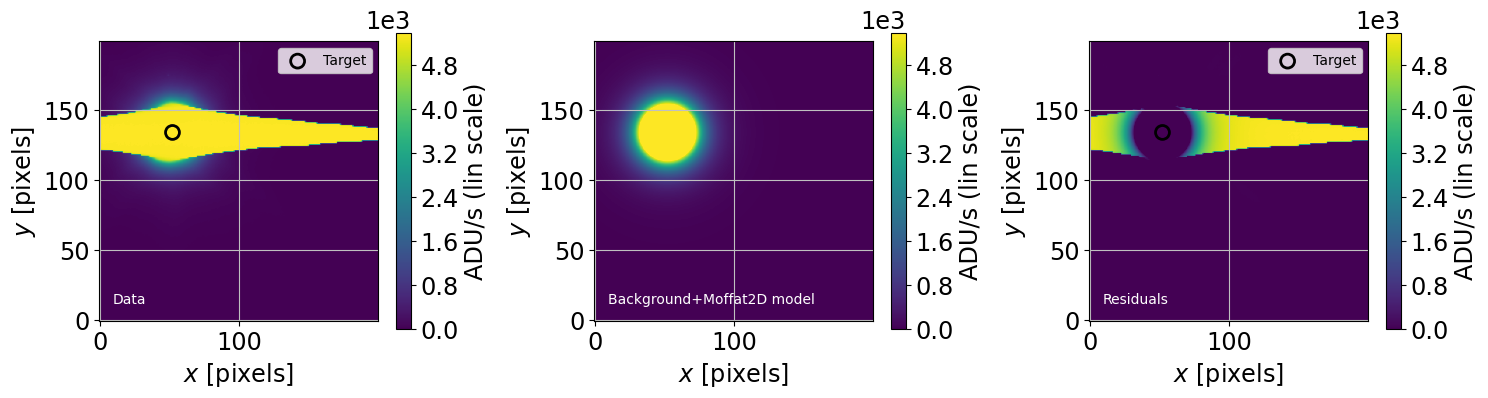

2022-12-07 14:22:10  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=5e-05.


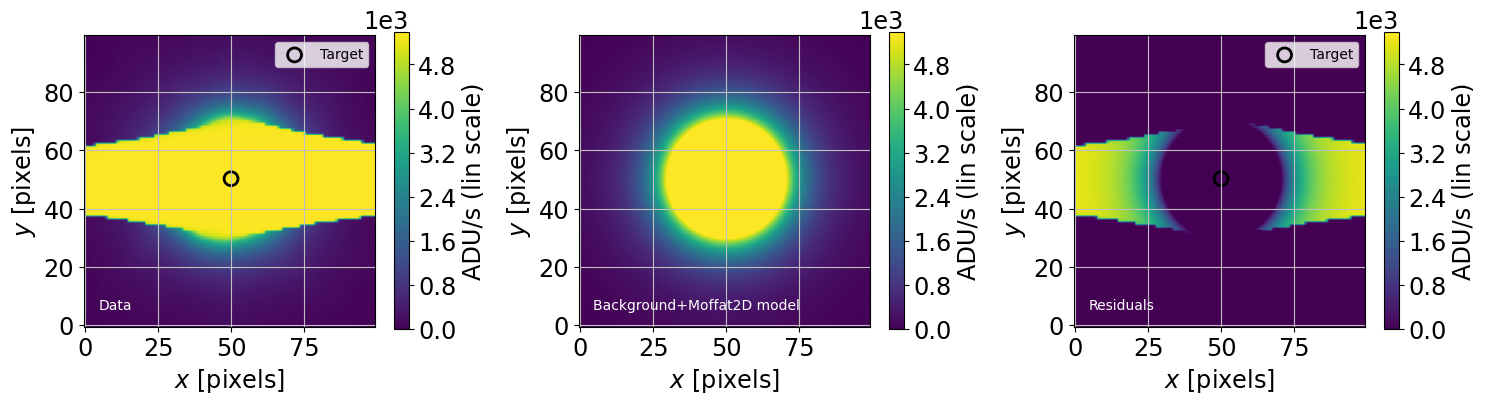

In [68]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [69]:
print(x1,y1)

301.9909581228111 1734.244249899516


## Check the location of 0th order and Analysis of the quality of its focus

In [70]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [71]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [72]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [73]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [74]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [75]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [76]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [77]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [78]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [79]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [80]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [81]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [82]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.5, 0.98, '7) exposure_2021110300501_postisrccd.fits')

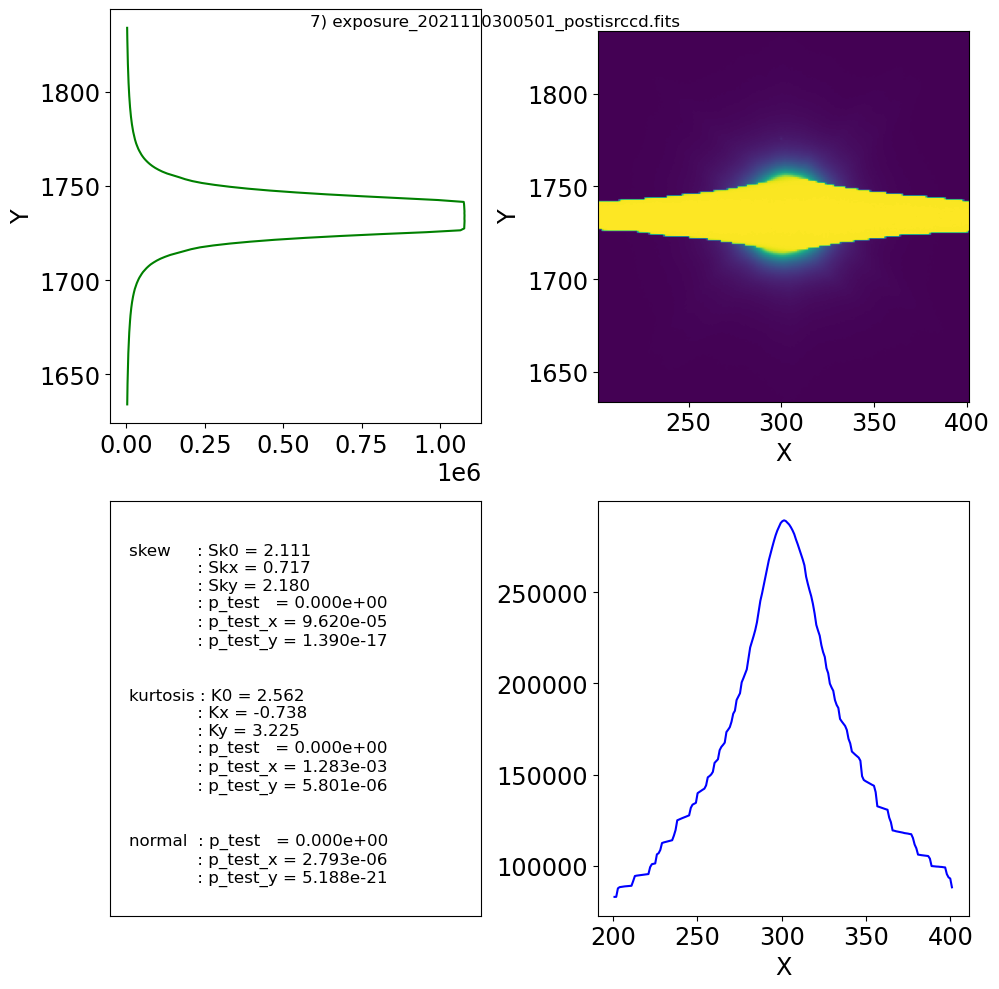

In [83]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title)

In [84]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [85]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

parameters.DEBUG=True
parameters.VERBOSE=True
parameters.DISPLAY=True
parameters.LIVE_FIT=False

In [86]:
filename

'/sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20211103/exposure_2021110300501_postisrccd.fits'

In [87]:
output_directory

'./outputs_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8'

2022-12-07 14:22:12  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2022-12-07 14:22:12  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2022/empty~holo4_003/20211103/exposure_2021110300501_postisrccd.fits...
2022-12-07 14:22:12  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: disperser	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: disperser	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
x spectractor_deconvolution_sigma_clip: 100	=> parameters.S

2022-12-07 14:22:12  Image      load_image           INFO   
	Loading disperser holo4_003...
2022-12-07 14:22:12  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg/spectractor/extractor/dispersers/holo4_003
2022-12-07 14:22:12  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of 0.2 degrees
2022-12-07 14:22:17  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1


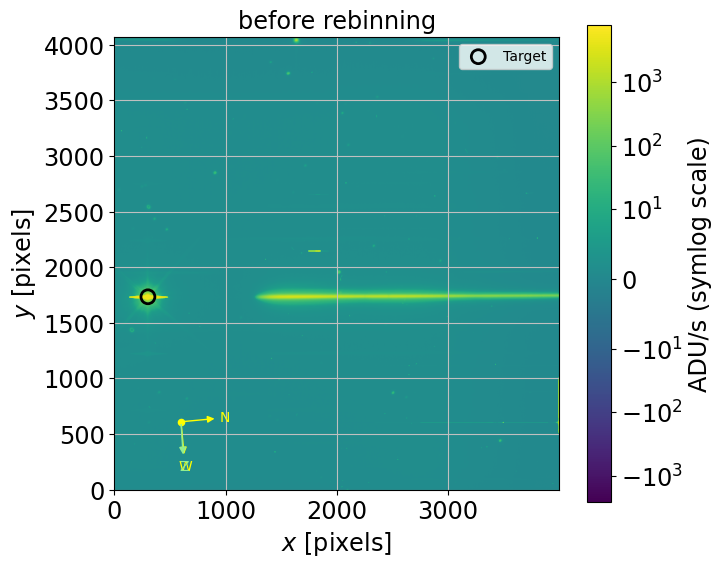

2022-12-07 14:22:20  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 301.99095812 1734.2442499 ]...
2022-12-07 14:22:20  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                   c0_1        
    ------------------ ---------------------- ---------------------
    28.089494691137087 0.00033420450510542006 -0.009799162041939648


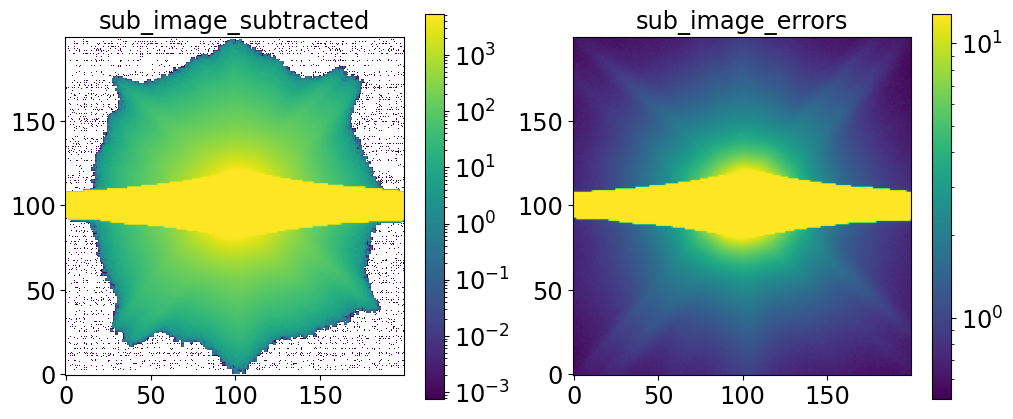

2022-12-07 14:22:23  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 21 iterations because the relative change of cost is below ftol=1.25e-05.


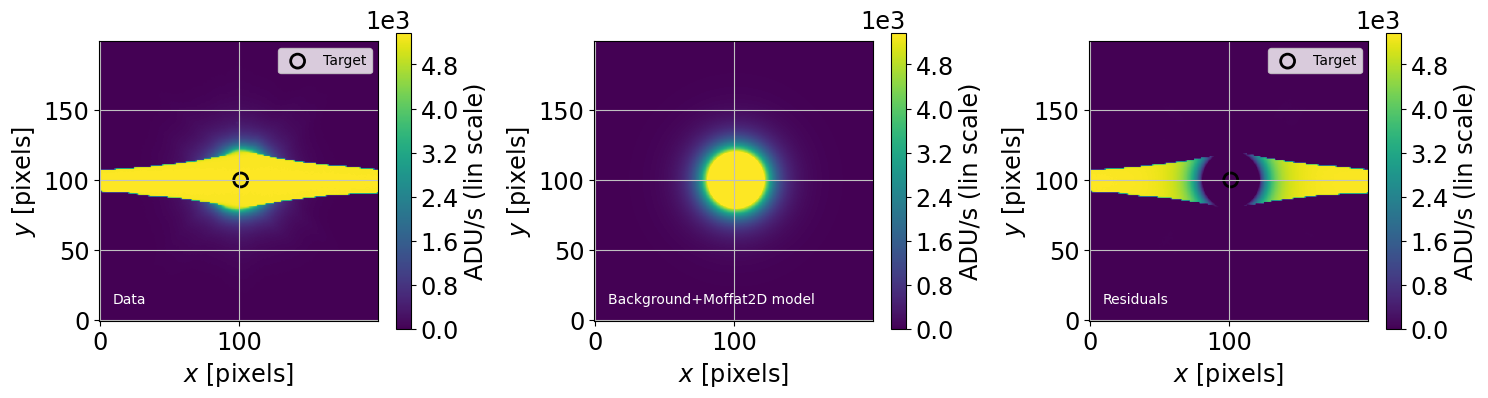

2022-12-07 14:22:24  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=5e-05.


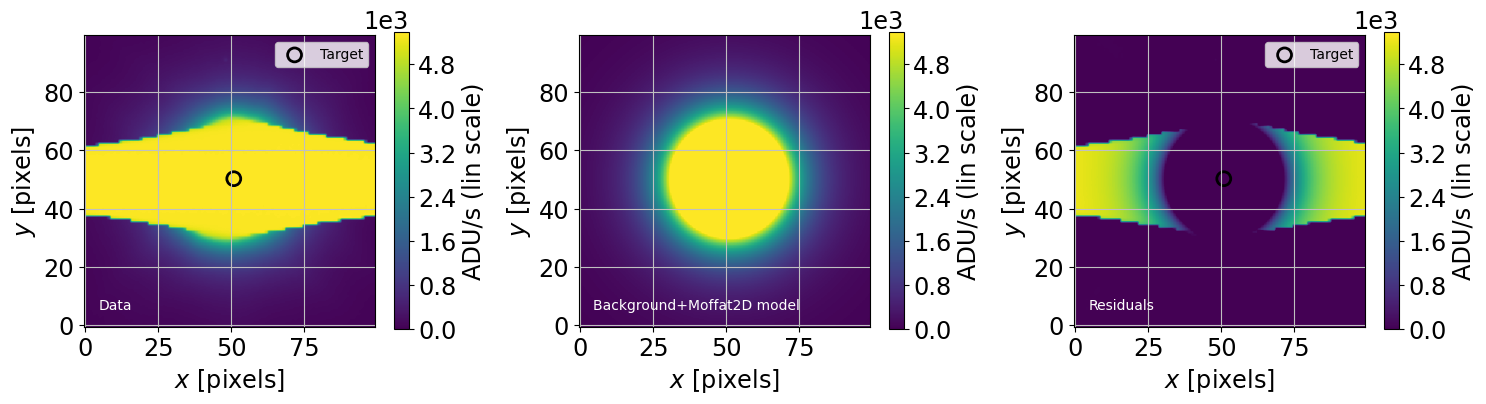

2022-12-07 14:22:25  Image      find_target          INFO   
	X,Y target position in pixels: 301.928,1734.248
2022-12-07 14:22:25  Image      turn_image           INFO   
	Rotate the image with angle theta=0.20 degree


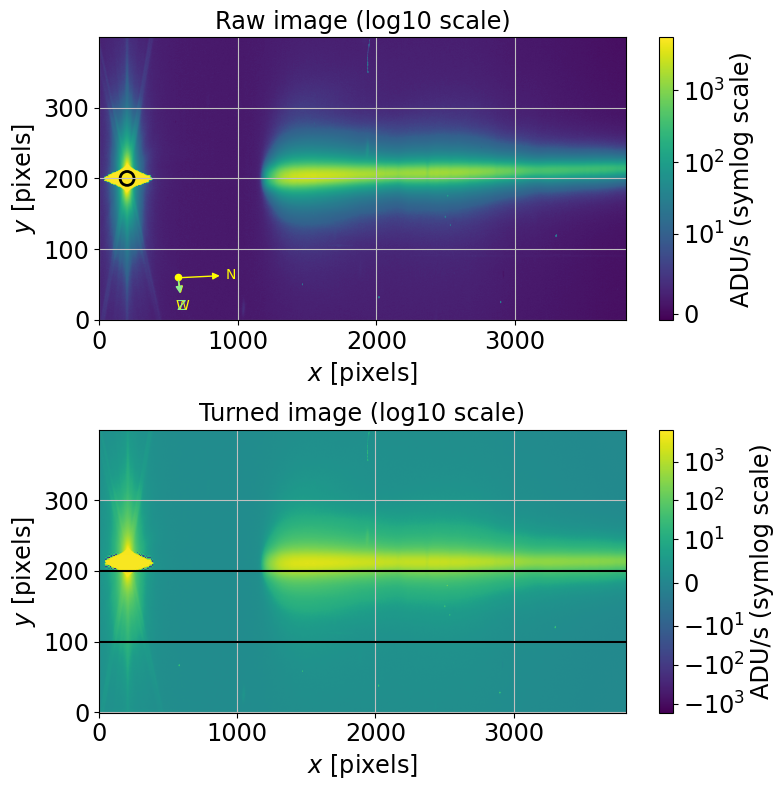

2022-12-07 14:22:35  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2022-12-07 14:22:35  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0               c0_1       
    ------------------ ------------------ ------------------
    1914.7372232383789 1.6096493893341641 1.3514670258220935


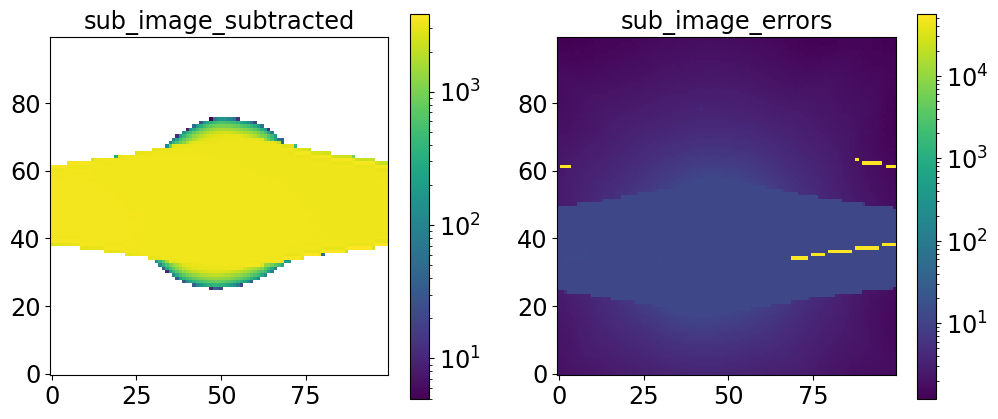

2022-12-07 14:22:36  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 5 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.
2022-12-07 14:22:36  Image      find_target_Moffat2D WARNING 
	X=60.56, Y=46.12 target position determination probably wrong: 10.6 pixels from profile detection (50.56, 49.71)


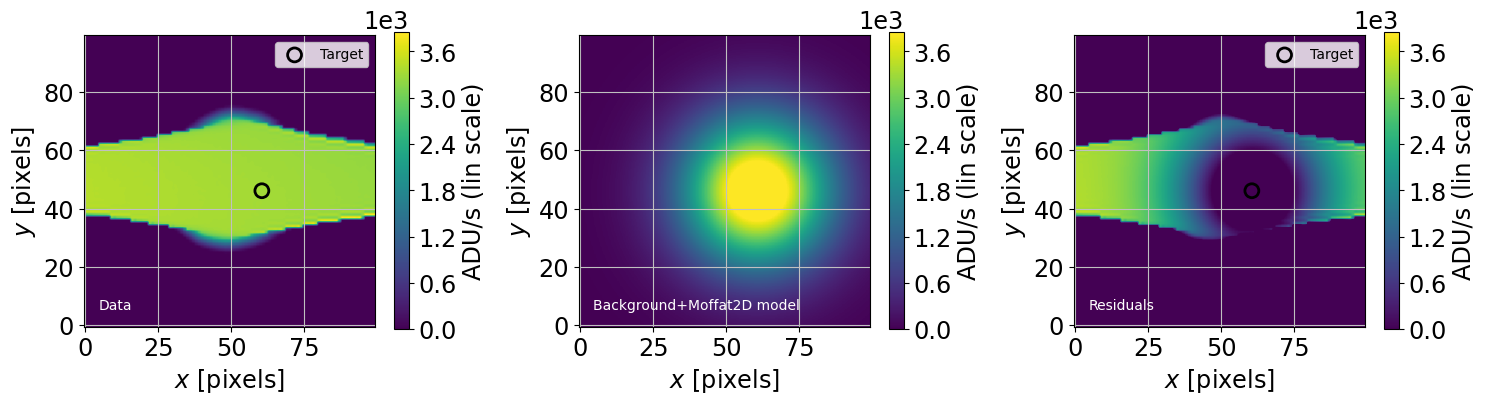

2022-12-07 14:22:36  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


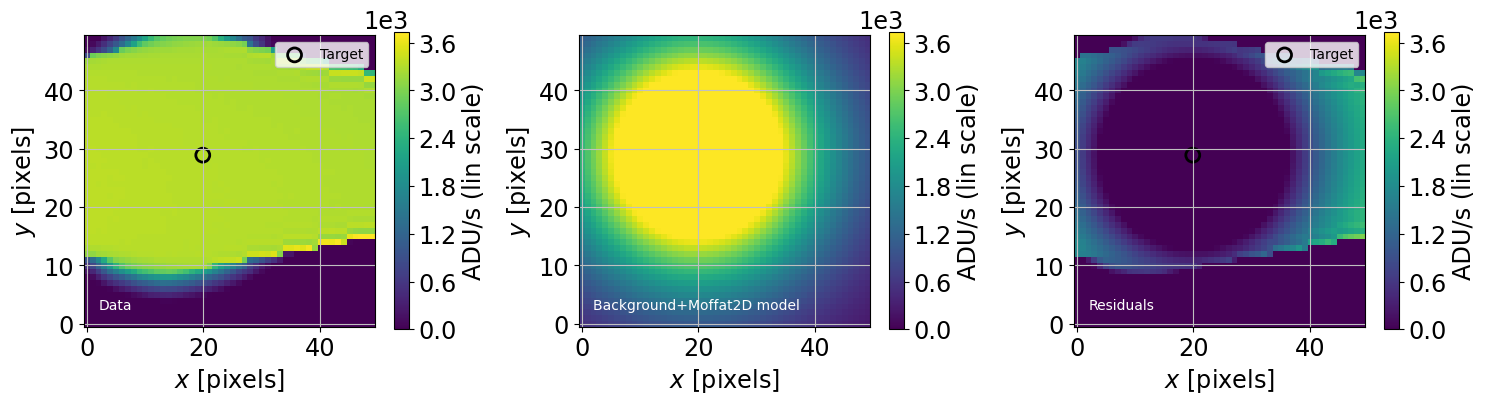

2022-12-07 14:22:37  Image      find_target          INFO   
	X,Y target position in pixels: 311.898,1746.910
2022-12-07 14:22:37  Spectrum   __init__             INFO   
	Spectrum info copied from image
2022-12-07 14:22:37  spectractor.extractor.extractor Spectractor          INFO   
	  ======================= PSF1D Extraction ====================================
2022-12-07 14:22:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= extract_spectrum_from_image =============================
2022-12-07 14:22:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 140 to 180 pixels
2022-12-07 14:22:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [1160:3464,1566:1926] (size (2304, 360))
        Use SegmentationImage.make_source_mask instead. [spectractor.extractor.background]
2022-

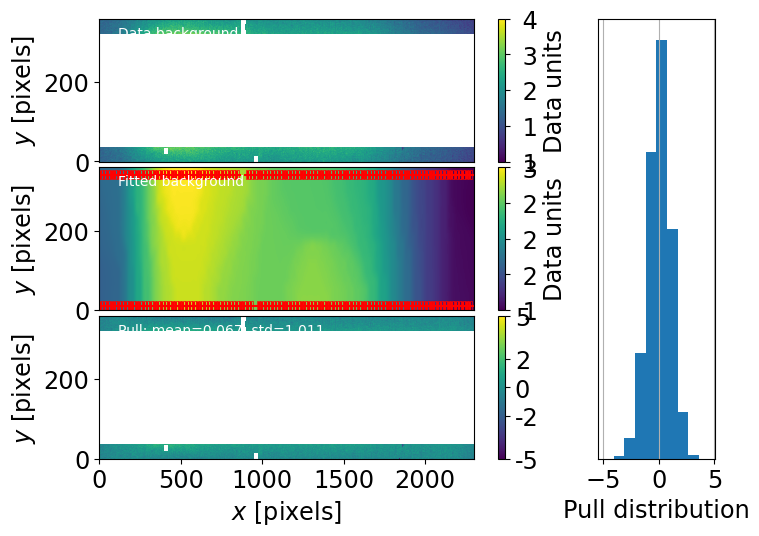

2022-12-07 14:22:39  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Fit the transverse profile =============================
2022-12-07 14:22:39  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
2022-12-07 14:22:40  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: stddev has a null Jacobian; parameter is fixed at its last known current value (1.0).
2022-12-07 14:22:40  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: stddev has a null Jacobian; parameter is fixed at its last known current value (1.0).
2022-12-07 14:22:40  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: stddev has a null Jacobian; parameter is fixed at its last known current value (1.0).
2022-12-07 14:22:40  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: stddev has a null Jacobian; parameter is fixed at its last known current value (1.0).
2022-12-07 14:22:40  spectracto

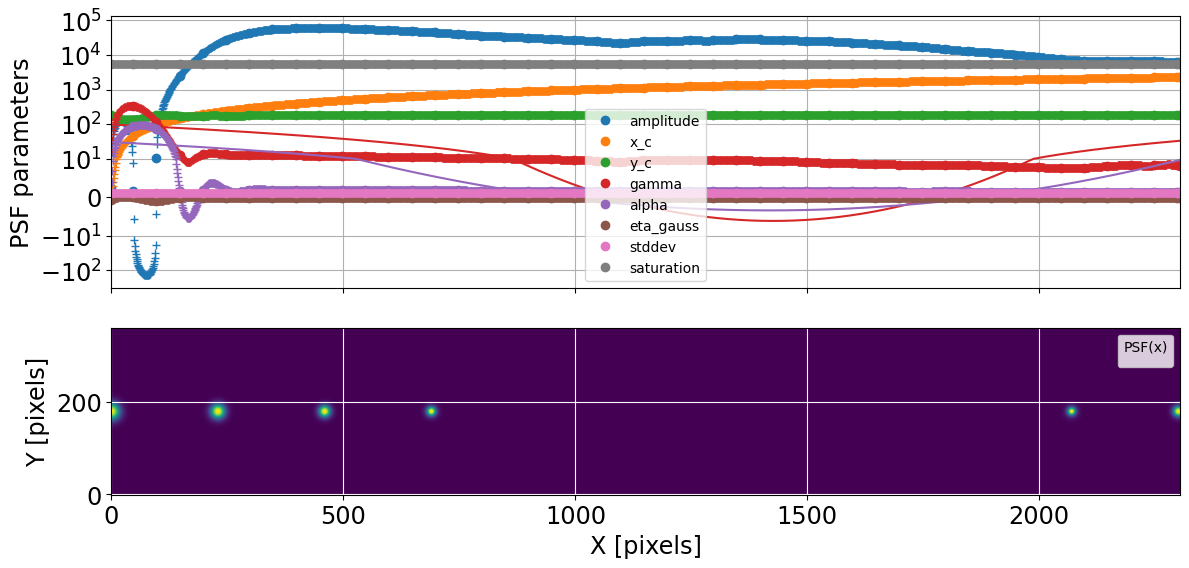

2022-12-07 14:22:49  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: stddev_1 has a null Jacobian; parameter is fixed at its last known current value (3.967419130694229e-17).
2022-12-07 14:22:49  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: stddev_2 has a null Jacobian; parameter is fixed at its last known current value (-1.1069885242923569e-16).
2022-12-07 14:22:49  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=7.7805e+06 initial chisq_red=84.423
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.12401981  0.28499537  0.4742407   3.27883702 -2.87824539  0.86466338
  0.63220557 -0.52758994  0.18306674  0.07200552 -0.02396832 -0.01577528
  0.06417292]
	New parameters: [-3.88608273e-01  1.20740358e+00 -7.70102675e-01  1.36620907e+01
 -5.87408926e+00  2.49288426e+00  2.32047594e+00 -8.43283729e-01
  2.35231894e-01 -8.45785780e-03 -1.04913931e-02 -3.37265706e-03
  1.06417292e+00]
	Final cost=5.2691e+06 final 

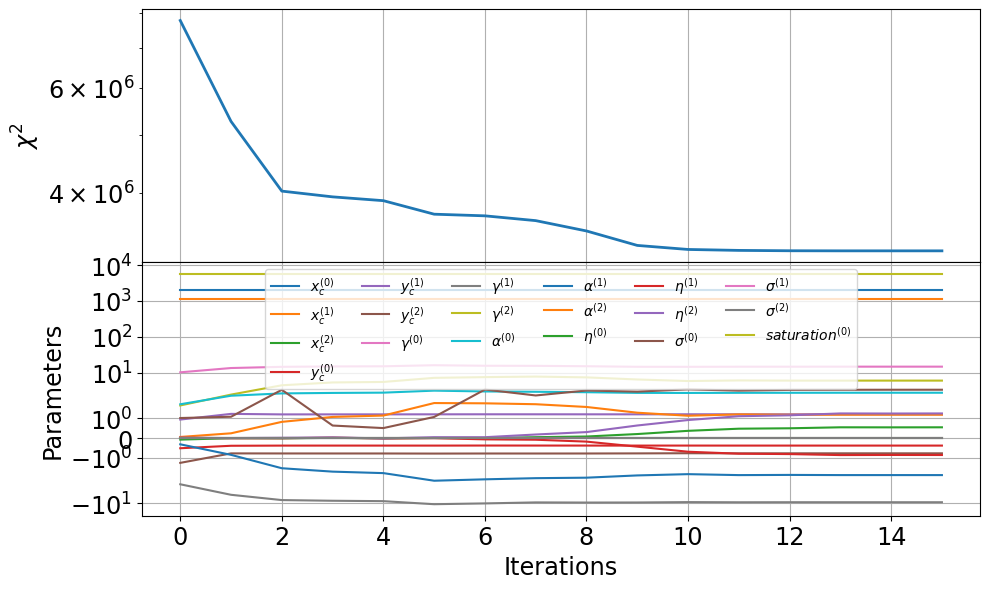

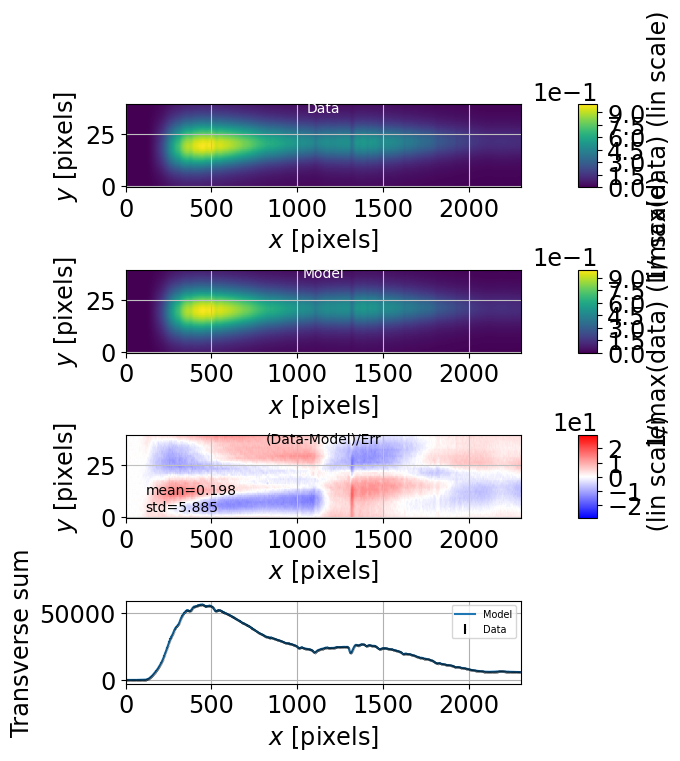

2022-12-07 14:23:25  ChromaticPSF1DFitWorkspace plot_correlation_matrix INFO   Save figure ./figures_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8/parameters_correlation.pdf.


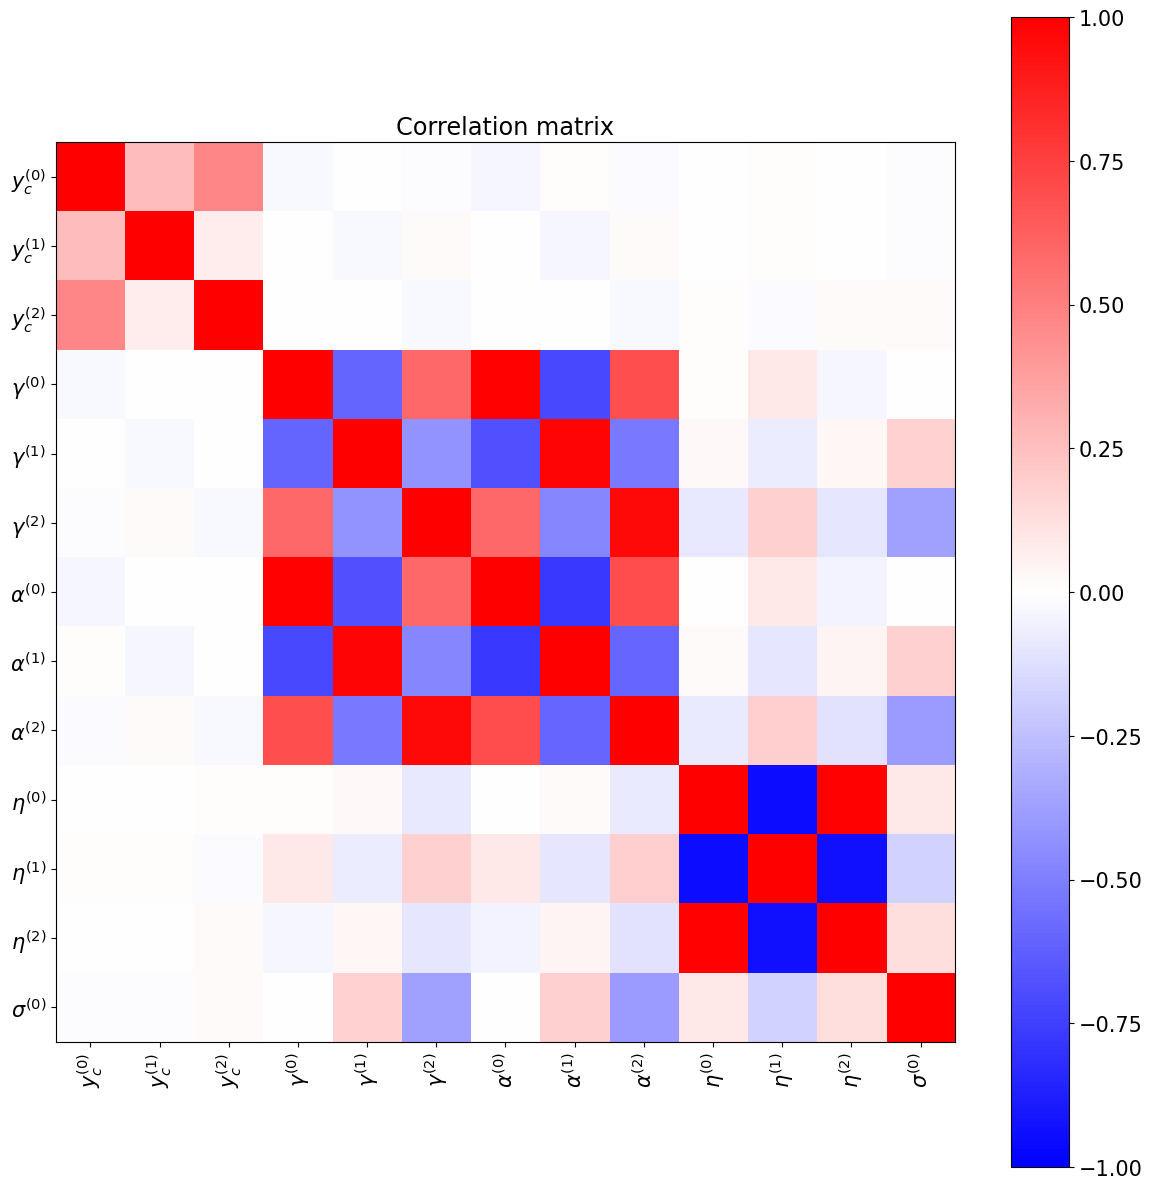

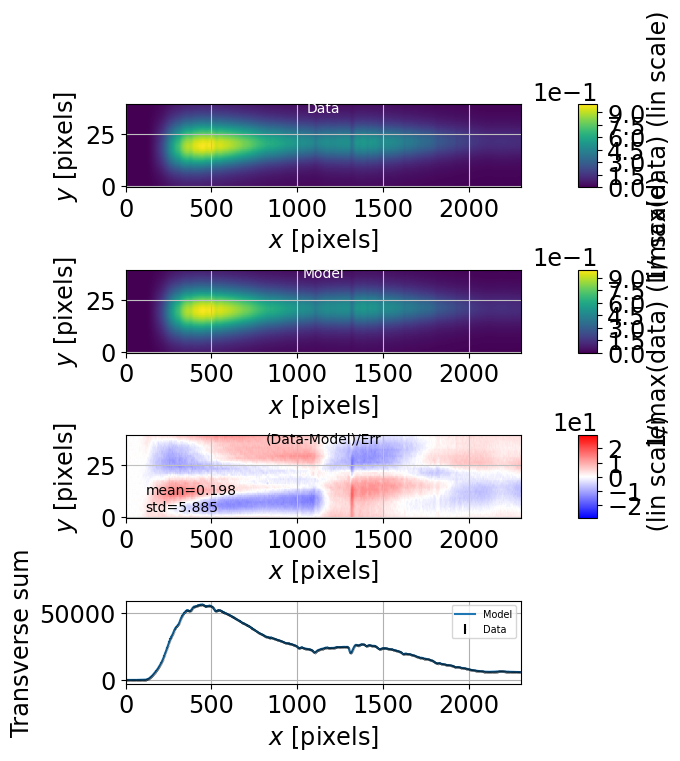

2022-12-07 14:23:31  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop raw image [1149:3453,1556:1925] (size (2304, 369))
2022-12-07 14:23:31  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Extract the non rotated background  =============================
        Use SegmentationImage.make_source_mask instead. [spectractor.extractor.background]
2022-12-07 14:23:31  astroquery _showwarning         WARNING AstropyDeprecationWarning: The make_source_mask function is deprecated and may be removed in a future version.
        Use SegmentationImage.make_source_mask instead.
2022-12-07 14:23:31  astroquery _showwarning         WARNING AstropyDeprecationWarning: "kernel" was deprecated in version 1.5 and will be removed in a future version. Instead, if filtering is desired, please input a convolved image directly into the "data" parameter.


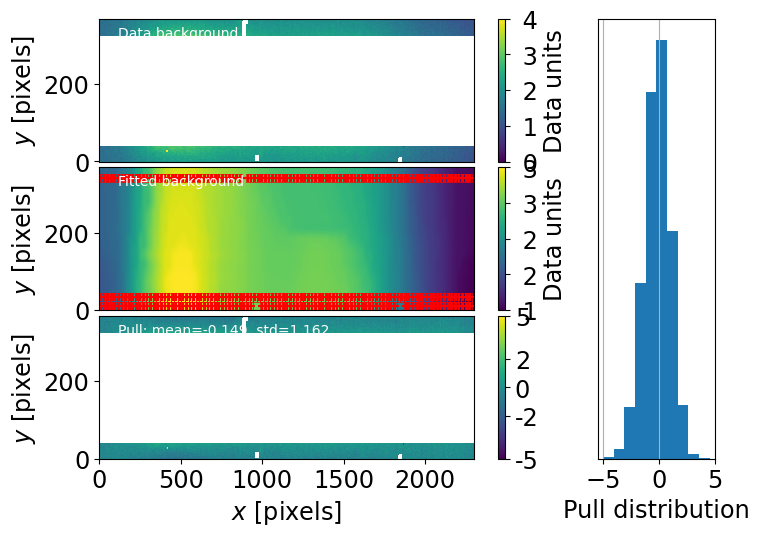

2022-12-07 14:23:33  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.306 ADU/s, RMS=0.394 ADU/s.
2022-12-07 14:23:33  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= first guess for lambdas  =============================
2022-12-07 14:23:33  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1149:3453,1556:1925] (size (2304, 369))
	New target position in spectrogram frame: [-847.0720409156266, 178.24780896262428]


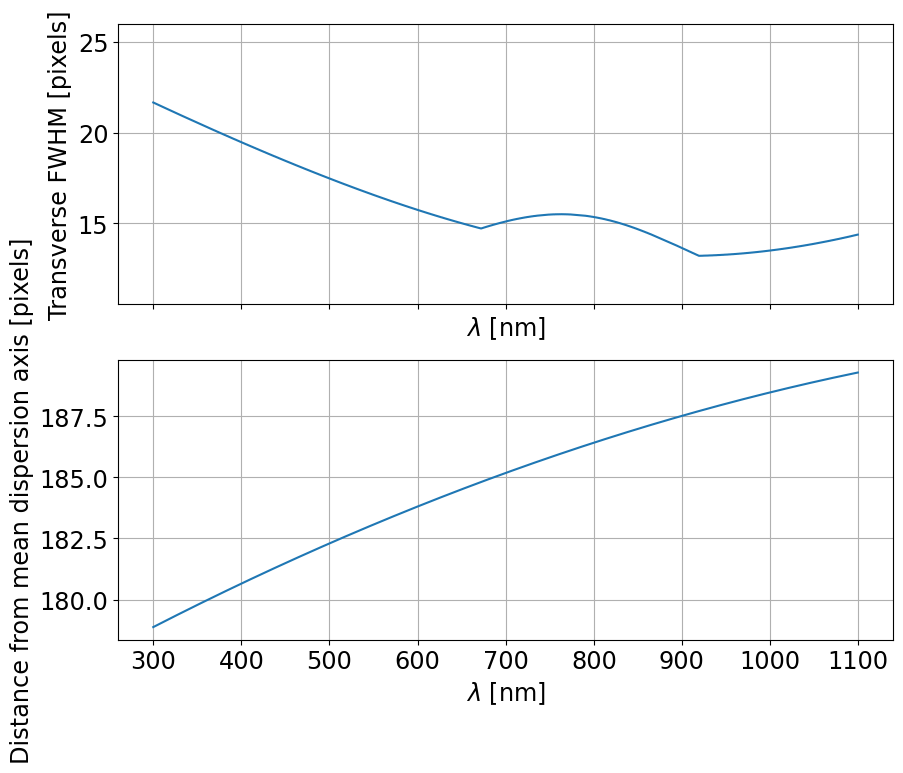

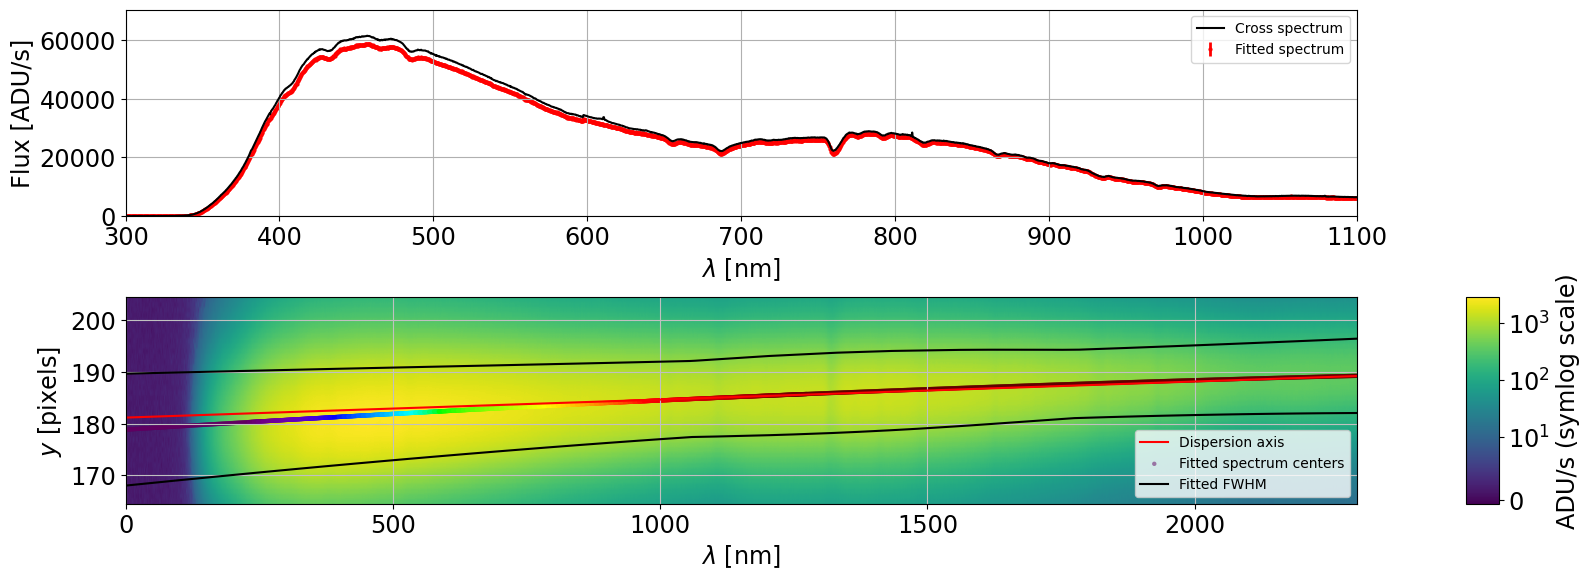

2022-12-07 14:23:35  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


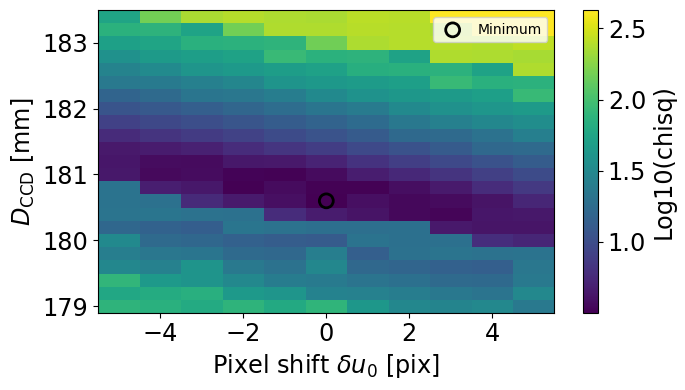

2022-12-07 14:24:39  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 0.127pix
	D = 180.640 mm (default: DISTANCE2CCD = 181.00 +/- 0.40 mm, -0.9 sigma shift)
2022-12-07 14:24:39  spectractor.extractor.extractor Spectractor          INFO   
	  ======================= FFM DECONVOLUTION =============================
2022-12-07 14:24:39  FullForwardModelFitWorkspace set_mask             INFO   
	Reset spectrogram mask with current parameters.
2022-12-07 14:24:46  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=0.1.
2022-12-07 14:24:47  spectractor.extractor.extractor run_ffm_minimisation INFO   
 --- Start FFM with adjust_spectrogram_position_parameters --- 
2022-12-07 14:28:24  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=6.0891e+07 initial chisq_red=539.35
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.41044602  0.01095113]
	New parameters: [-0.4104460

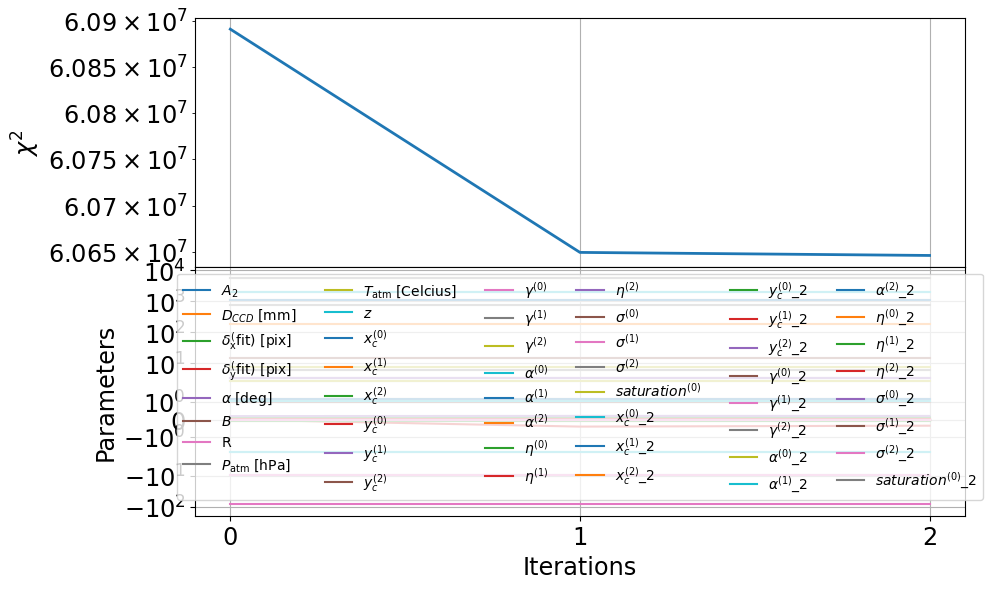

2022-12-07 14:32:18  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8/ffm_bestfit.pdf.
2022-12-07 14:32:20  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8/ffm_bestfit_2.pdf.


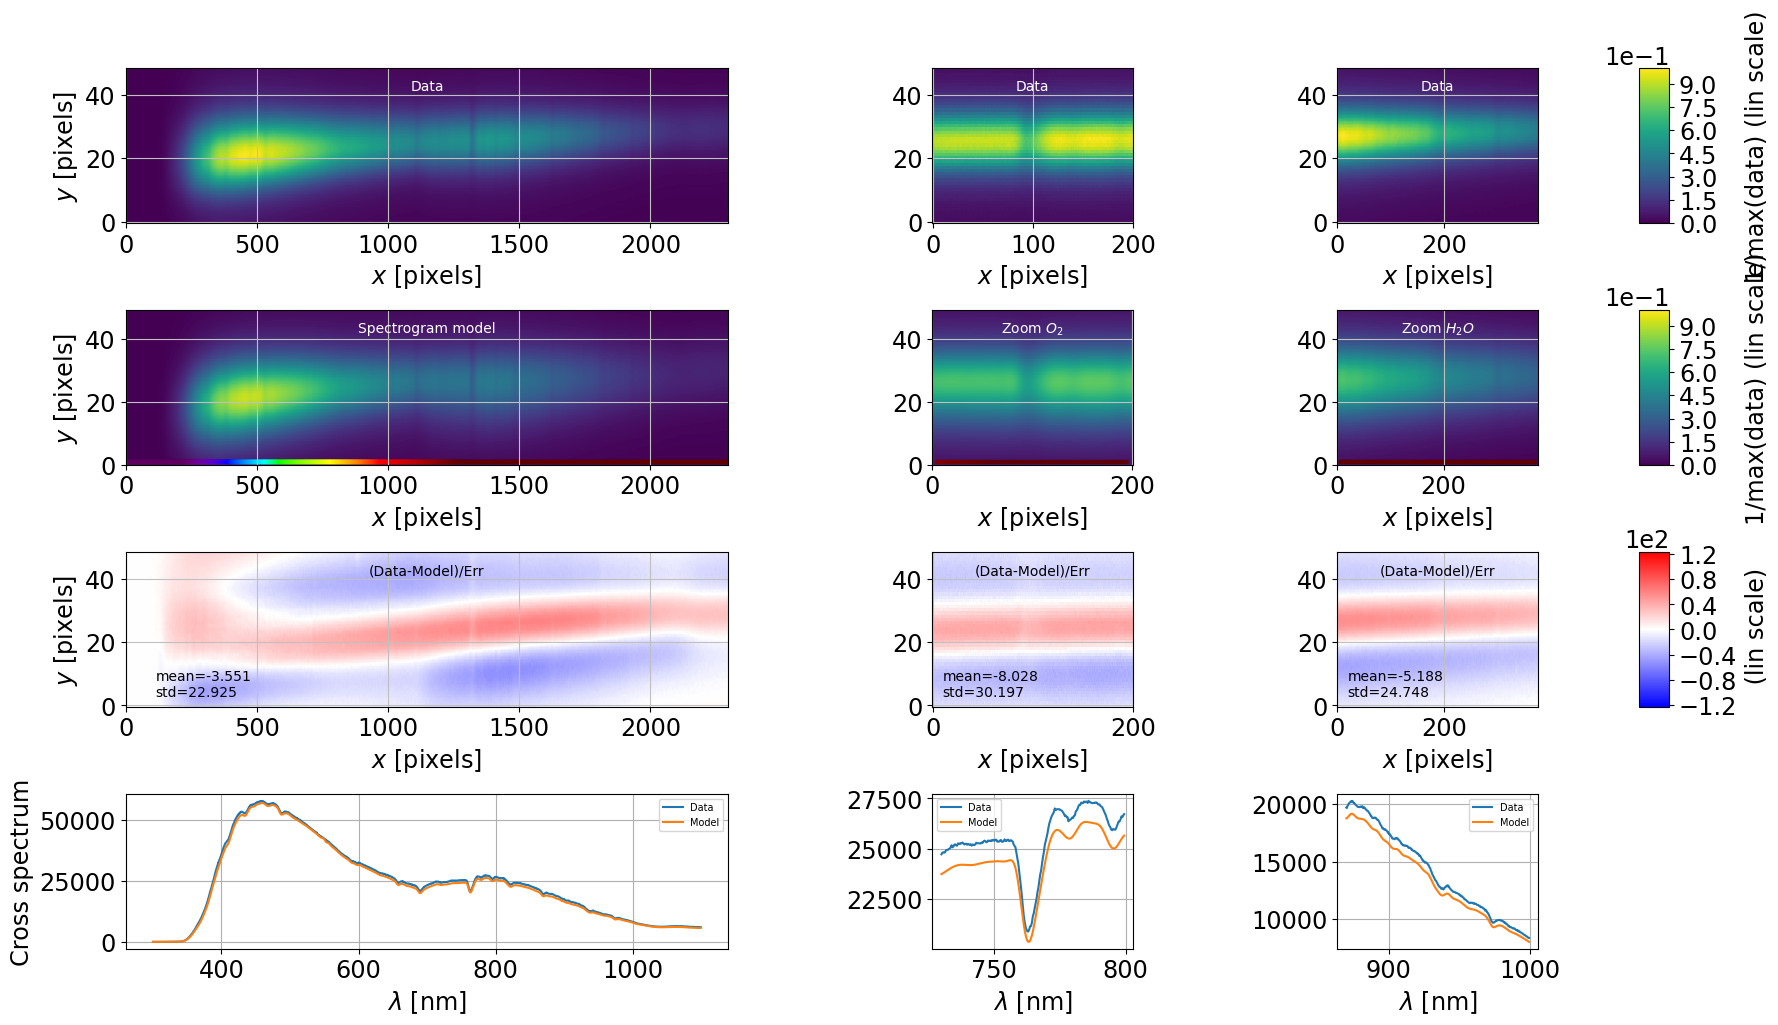

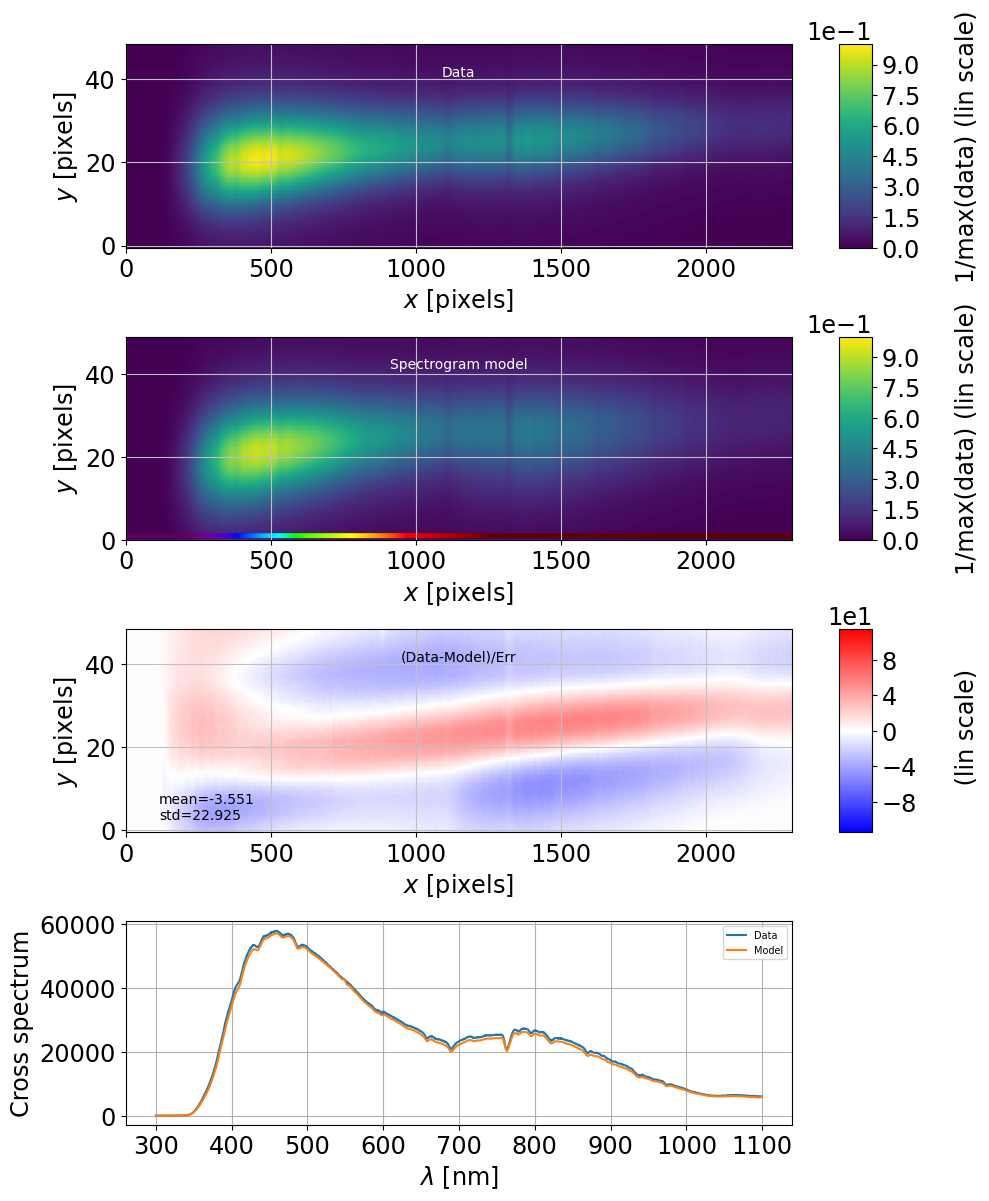

2022-12-07 14:32:23  FullForwardModelFitWorkspace plot_correlation_matrix INFO   Save figure ./figures_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8/parameters_correlation.pdf.


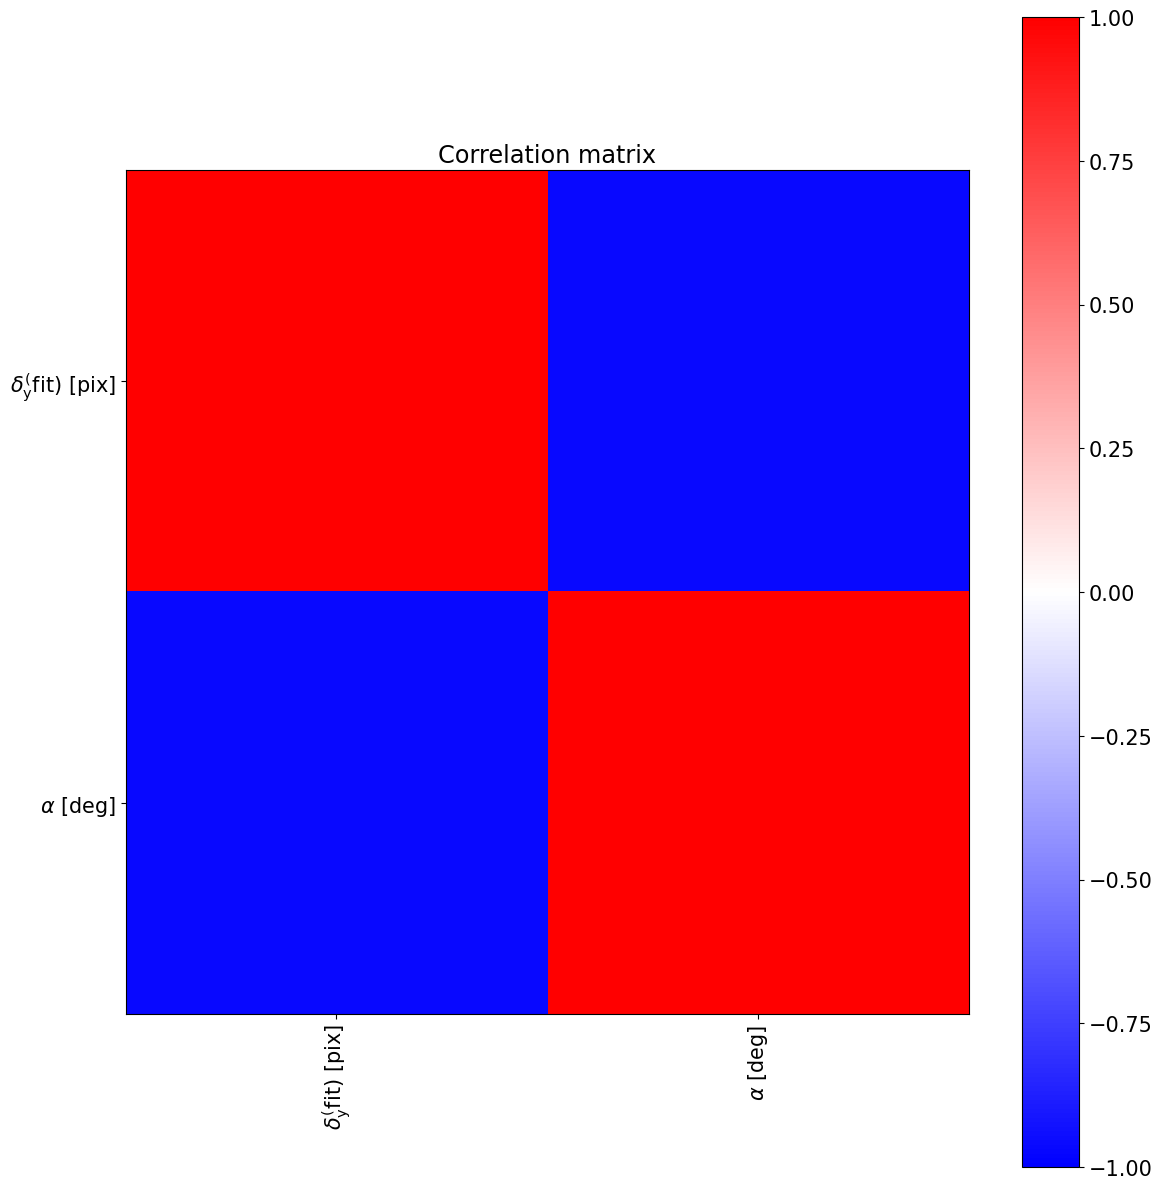

2022-12-07 14:32:23  FullForwardModelFitWorkspace set_mask             INFO   
	Reset spectrogram mask with current parameters.
2022-12-07 14:33:06  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8/ffm_bestfit.pdf.
2022-12-07 14:33:08  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20211103_empty~holo4_003_config_DECONVOLUTION_FFMvDec2022_nb_8/ffm_bestfit_2.pdf.


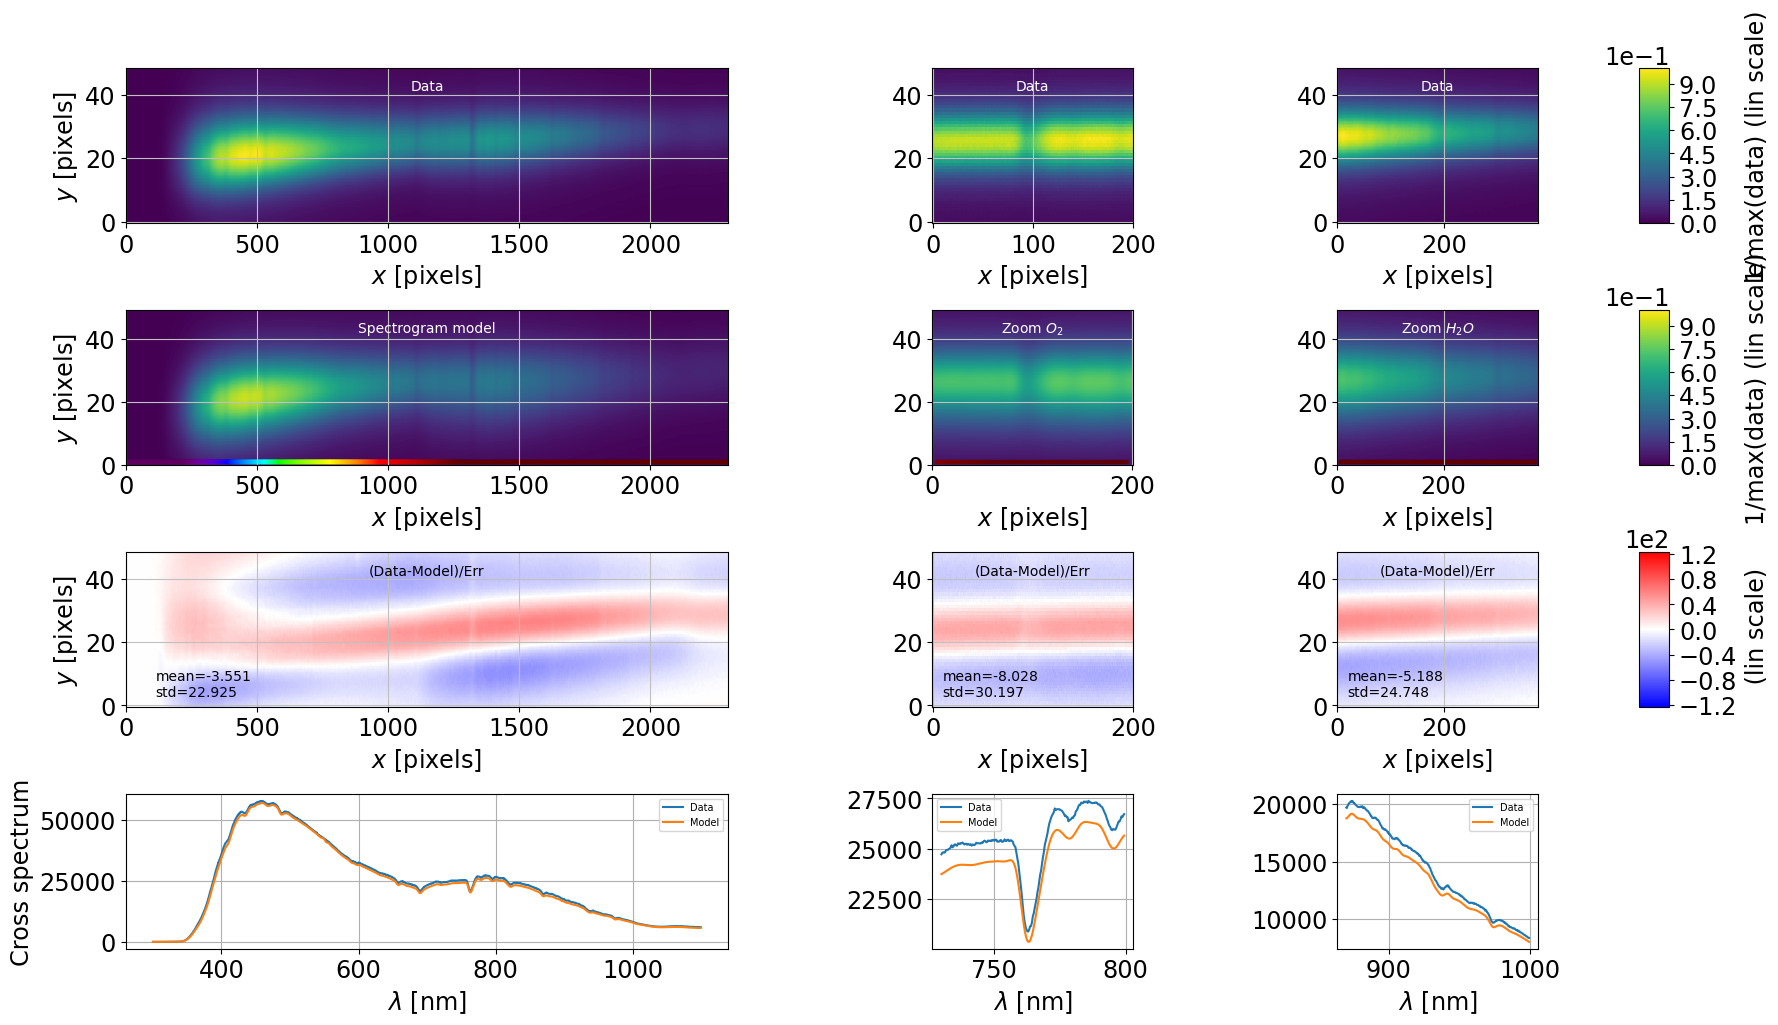

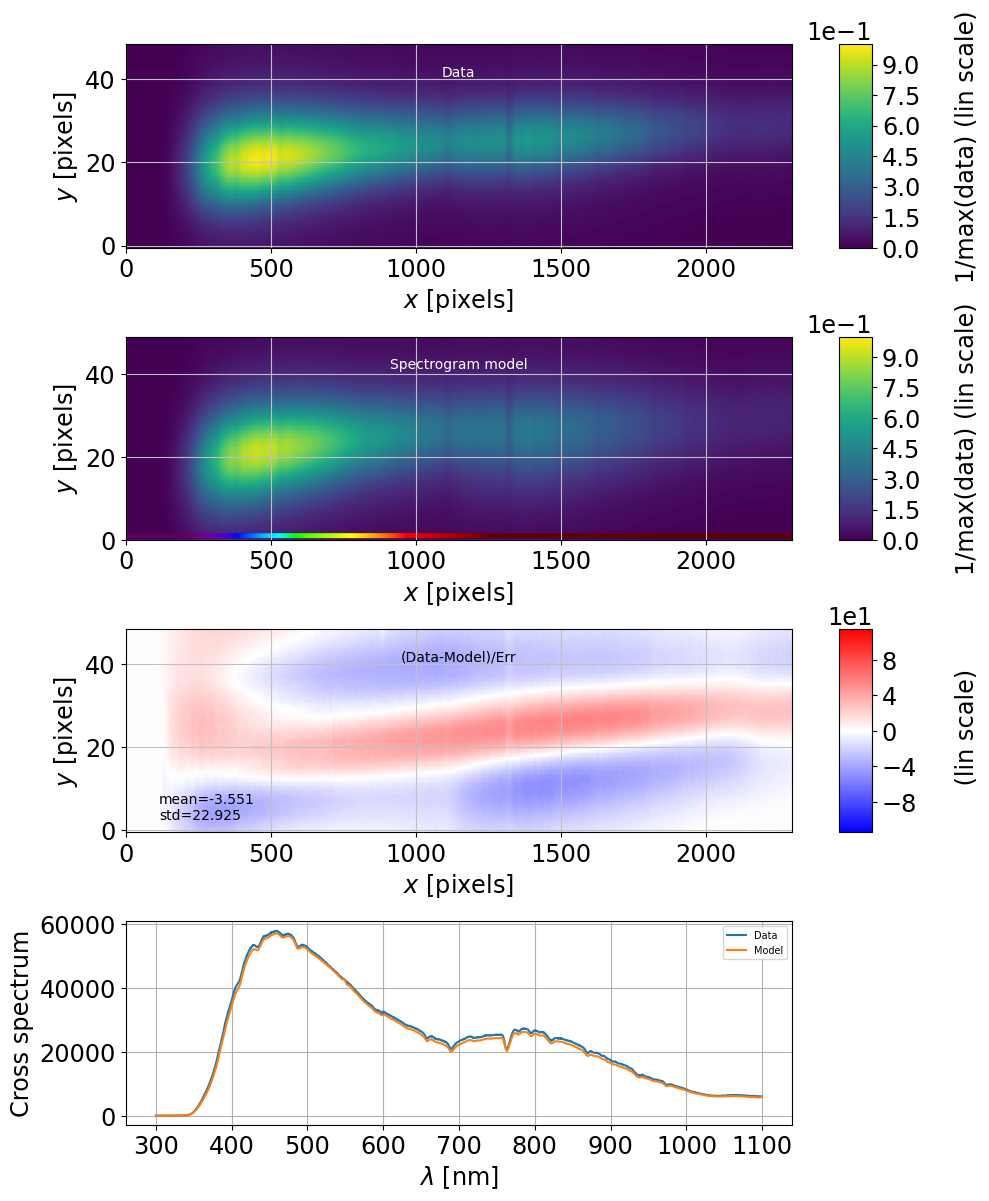

2022-12-07 14:33:11  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80640130e+02  1.27264516e-01 -3.57151218e-01
  2.09274163e-01  1.00000000e+00 -8.47235767e+01  7.40100000e+02
  7.50000000e+00  1.07939471e+00  1.99958941e+03  1.15149298e+03
 -1.23464659e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.49191551e+01 -9.46160003e+00  6.10608992e+00  2.80950867e+00
 -1.85648188e+00  1.16608408e+00 -5.47793376e-02 -9.54230534e-02
  2.62833708e-02  3.40403846e+00  4.29833773e-16  8.61368482e-16
  5.66666667e+03  1.99958941e+03  1.15149298e+03 -1.23464659e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.49191551e+01
 -9.46160003e+00  6.10608992e+00  2.80950867e+00 -1.85648188e+00
  1.16608408e+00 -5.47793376e-02 -9.54230534e-02  2.62833708e-02
  3.40403846e+00  4.29833773e-16  8.61368482e-16  5.66666667e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'P [hPa]', 'T [Celsius]', 'z', 'x_c_0

In [ ]:
if FLAG_RUNWITHEXCEPTIONS:
    try:
        spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)
    except:
        errtype = sys.exc_info()[0]  # E.g. <class 'PermissionError'>
        description = sys.exc_info()[1]   # E.g. [Errno 13] Permission denied: ...
        
        print("\t +++++++++++++++++++++ Exception occured +++++++++++++++++++++++++++++++++++++++++")
        print(f"\t >>>>>  errtype = {errtype}")
        print(f"\t >>>>>> description = {description}")
else:
    spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)

In [ ]:
spectrum.plot_spectrum(force_lines=True) 

# Backup output

- If no crash occurs, arrive here

./outputs_process_holo_config_DECONVOLUTION_PSF2D

In [ ]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [ ]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    
    if not os.path.isdir(path_toptoptopoutput_spectractor):
        os.mkdir(path_toptoptopoutput_spectractor)
    
    if not os.path.isdir(path_toptopoutput_spectractor):
        os.mkdir(path_toptopoutput_spectractor) 
        
    if configdir !="":
    # top directory    
        if not os.path.isdir(path_topoutput_spectractor):
            os.mkdir(path_topoutput_spectractor)   
            
            
        if not os.path.isdir(path_output_spectractor):
            os.mkdir(path_output_spectractor)
  
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("******************************** SUCCESS ********************************************")

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("finalpath_output_spectractor = ",finalpath_output_spectractor)

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
output_directory